# 📊 Preprocessing des Données DVF

**Objectif** : Nettoyer et préparer les données foncières DVF pour l'analyse d'investissement immobilier.

**Période analysée** : 2024

**Étapes principales** :
1. Chargement et exploration initiale
2. Nettoyage des valeurs manquantes
3. Filtrage temporel
4. Création de variables dérivées
5. Validation et export des données nettoyées

In [10]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Ajout du module utilitaire
sys.path.append('../src')
from dvf_utils import DVFDataProcessor, load_dvf_data

print("✅ Bibliothèques importées avec succès")

✅ Bibliothèques importées avec succès


## 1. 📥 Chargement des Données

Chargement du fichier DVF et exploration initiale de la structure des données.

In [11]:
# Chargement des données DVF avec gestion de l'encodage et du séparateur
data_path = '../assets/dataset.csv'

# Essayer différents encodages pour les fichiers DVF français
encodings = ['utf-8', 'iso-8859-1', 'windows-1252', 'cp1252']
df_raw = None

for encoding in encodings:
    try:
        # DVF utilise généralement le point-virgule comme séparateur
        df_raw = pd.read_csv(data_path, low_memory=False, encoding=encoding, sep=';')
        print(f"✅ Données chargées avec encodage {encoding} : {df_raw.shape[0]} lignes, {df_raw.shape[1]} colonnes")
        break
    except UnicodeDecodeError:
        continue

if df_raw is None:
    # Si aucun encodage ne fonctionne, essayer avec errors='ignore'
    df_raw = pd.read_csv(data_path, low_memory=False, encoding='utf-8', errors='ignore', sep=';')
    print(f"✅ Données chargées avec encodage UTF-8 (errors='ignore') : {df_raw.shape[0]} lignes, {df_raw.shape[1]} colonnes")

print(f"📊 Dimensions du dataset : {df_raw.shape}")
if 'date_mutation' in df_raw.columns:
    # Correction : format français jour/mois/année
    df_raw['date_mutation'] = pd.to_datetime(df_raw['date_mutation'], dayfirst=True, errors='coerce')
    print(f"📅 Période couverte : {df_raw['date_mutation'].min()} à {df_raw['date_mutation'].max()}")

✅ Données chargées avec encodage iso-8859-1 : 85065 lignes, 40 colonnes
📊 Dimensions du dataset : (85065, 40)
📅 Période couverte : 2024-01-02 00:00:00 à 2024-12-31 00:00:00


In [12]:
# Exploration de la structure
print("🔍 Colonnes disponibles :")
print(df_raw.columns.tolist())
print("\n📋 Informations générales :")
df_raw.info()

🔍 Colonnes disponibles :
['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation', 'valeur_fonciere', 'adresse_numero', 'adresse_suffixe', 'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune', 'nom_commune', 'code_departement', 'ancien_code_commune', 'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle', 'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale', 'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude']

📋 Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85065 entries, 0 to 85064
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype         
--

In [13]:
# Aperçu des premières lignes
print("👀 Aperçu des données :")
df_raw.head()

👀 Aperçu des données :


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2024-1136527,2024-01-04,1.0,Vente,302000.0,11.0,NaN,RUE DE LA VARENNE,9614,94100.0,...,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.471997,48.809629
1,2024-1136527,2024-01-04,1.0,Vente,302000.0,11.0,NaN,RUE DE LA VARENNE,9614,94100.0,...,Appartement,53.0,3.0,NaN,NaN,NaN,NaN,NaN,2.471997,48.809629
2,2024-1136528,2024-01-02,2.0,Vente,NaN,NaN,NaN,LES COURTILLES,B025,94500.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,302.0,2.505535,48.818976
3,2024-1136528,2024-01-02,2.0,Vente,NaN,NaN,NaN,LES COURTILLES,B025,94500.0,...,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,48.0,2.506129,48.819288
4,2024-1136528,2024-01-02,2.0,Vente,NaN,NaN,NaN,LES COURTILLES,B025,94500.0,...,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,82.0,2.506131,48.819341


## 2. 🔍 Analyse des Valeurs Manquantes

Identification et traitement des valeurs manquantes pour les colonnes critiques.

In [14]:
# Analyse des valeurs manquantes
missing_data = df_raw.isnull().sum()
missing_percent = (missing_data / len(df_raw)) * 100

missing_df = pd.DataFrame({
    'Colonne': missing_data.index,
    'Valeurs_manquantes': missing_data.values,
    'Pourcentage': missing_percent.values
}).sort_values('Pourcentage', ascending=False)

# Affichage des colonnes avec des valeurs manquantes
missing_significant = missing_df[missing_df['Pourcentage'] > 0]
print("🚨 Colonnes avec valeurs manquantes :")
print(missing_significant.to_string(index=False))

🚨 Colonnes avec valeurs manquantes :
                     Colonne  Valeurs_manquantes  Pourcentage
          ancien_nom_commune               85065   100.000000
          ancien_id_parcelle               85065   100.000000
         ancien_code_commune               85065   100.000000
         lot5_surface_carrez               85028    99.956504
         lot4_surface_carrez               84939    99.851878
                 lot5_numero               84769    99.652031
               numero_volume               84693    99.562687
         lot3_surface_carrez               84608    99.462764
                 lot4_numero               84359    99.170046
     nature_culture_speciale               82932    97.492506
code_nature_culture_speciale               82932    97.492506
                 lot3_numero               82915    97.472521
             adresse_suffixe               79641    93.623700
         lot2_surface_carrez               78610    92.411685
                 lot2_numero     

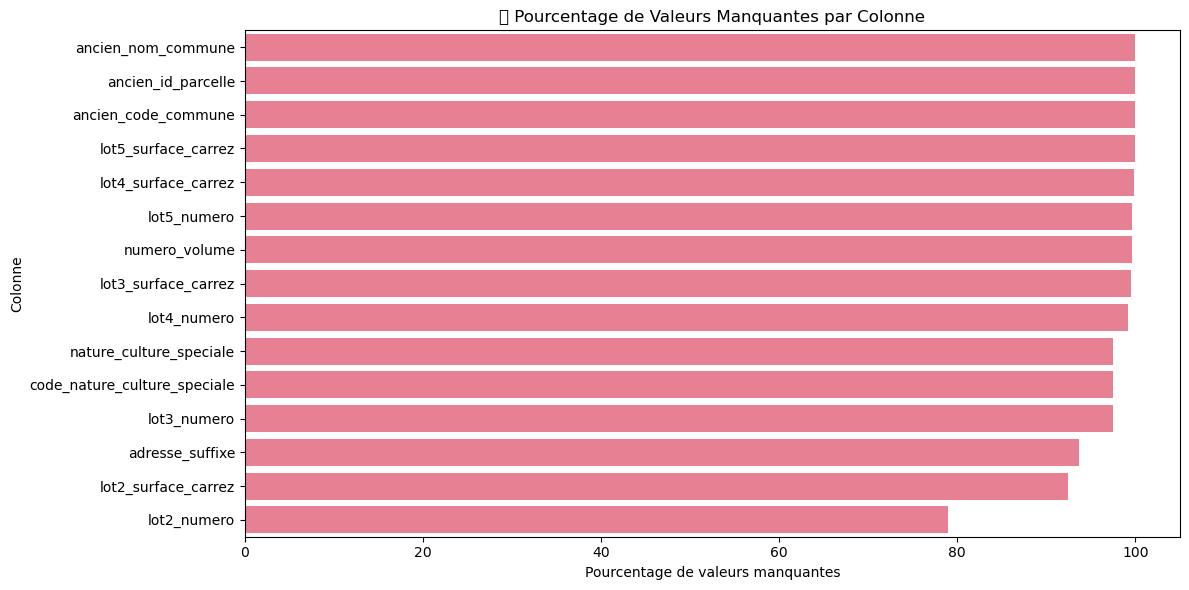

In [15]:
# Visualisation des valeurs manquantes
plt.figure(figsize=(12, 6))
missing_top = missing_significant.head(15)
sns.barplot(data=missing_top, x='Pourcentage', y='Colonne')
plt.title('📊 Pourcentage de Valeurs Manquantes par Colonne')
plt.xlabel('Pourcentage de valeurs manquantes')
plt.tight_layout()
plt.show()

## 3. 🧹 Nettoyage des Données

Application des règles de nettoyage définies dans la spécification.

In [16]:
# Initialisation du processeur de données
processor = DVFDataProcessor(df_raw)

# Nettoyage des données pour la période 2024 (données disponibles)
# Note: Le dataset contient uniquement des données 2024, nous adaptons donc le traitement
print("🧹 Début du nettoyage des données...")
df_clean = processor.clean_data(start_year=2024, end_year=2024)

# Rapport de nettoyage
cleaning_report = processor.get_cleaning_report()
print("📊 Rapport de Nettoyage :")
print(f"   • Lignes originales : {cleaning_report['original_rows']:,}")
print(f"   • Lignes conservées : {cleaning_report['cleaned_rows']:,}")
print(f"   • Lignes supprimées : {cleaning_report['removed_rows']:,}")
print(f"   • Pourcentage supprimé : {cleaning_report['removal_percentage']}%")

🧹 Début du nettoyage des données...
📊 Rapport de Nettoyage :
   • Lignes originales : 85,065
   • Lignes conservées : 29,427
   • Lignes supprimées : 55,638
   • Pourcentage supprimé : 65.41%


In [17]:
# Vérification des colonnes essentielles après nettoyage
essential_cols = ['valeur_fonciere', 'surface_reelle_bati', 'prix_m2', 'nom_commune', 'date_mutation']

print("✅ Vérification des colonnes essentielles :")
for col in essential_cols:
    if col in df_clean.columns:
        missing = df_clean[col].isnull().sum()
        print(f"   • {col}: {missing} valeurs manquantes ({missing/len(df_clean)*100:.1f}%)")
    else:
        print(f"   ❌ {col}: Colonne manquante")

✅ Vérification des colonnes essentielles :
   • valeur_fonciere: 0 valeurs manquantes (0.0%)
   • surface_reelle_bati: 0 valeurs manquantes (0.0%)
   • prix_m2: 0 valeurs manquantes (0.0%)
   • nom_commune: 0 valeurs manquantes (0.0%)
   • date_mutation: 0 valeurs manquantes (0.0%)


## 4. 📈 Création de Variables Dérivées

Calcul des variables supplémentaires nécessaires pour l'analyse.

In [18]:
# Ajout de variables temporelles
df_clean['annee_mutation'] = df_clean['date_mutation'].dt.year
df_clean['mois_mutation'] = df_clean['date_mutation'].dt.month
df_clean['trimestre_mutation'] = df_clean['date_mutation'].dt.quarter

# Création du code département si pas présent
if 'code_departement' not in df_clean.columns and 'code_postal' in df_clean.columns:
    df_clean['code_departement'] = df_clean['code_postal'].astype(str).str[:2]

# Catégorisation des surfaces
def categorize_surface(surface):
    if surface < 30:
        return 'Très petit (<30m²)'
    elif surface < 50:
        return 'Petit (30-50m²)'
    elif surface < 80:
        return 'Moyen (50-80m²)'
    elif surface < 120:
        return 'Grand (80-120m²)'
    else:
        return 'Très grand (>120m²)'

df_clean['categorie_surface'] = df_clean['surface_reelle_bati'].apply(categorize_surface)

# Catégorisation des prix au m²
def categorize_prix_m2(prix_m2):
    if prix_m2 < 2000:
        return 'Abordable (<2000€/m²)'
    elif prix_m2 < 4000:
        return 'Modéré (2000-4000€/m²)'
    elif prix_m2 < 6000:
        return 'Élevé (4000-6000€/m²)'
    else:
        return 'Très élevé (>6000€/m²)'

df_clean['categorie_prix_m2'] = df_clean['prix_m2'].apply(categorize_prix_m2)

print("✅ Variables dérivées créées :")
print(f"   • Variables temporelles : annee_mutation, mois_mutation, trimestre_mutation")
print(f"   • Catégories de surface : {df_clean['categorie_surface'].value_counts().to_dict()}")
print(f"   • Catégories de prix au m² : {df_clean['categorie_prix_m2'].value_counts().to_dict()}")

✅ Variables dérivées créées :
   • Variables temporelles : annee_mutation, mois_mutation, trimestre_mutation
   • Catégories de surface : {'Moyen (50-80m²)': 10671, 'Grand (80-120m²)': 6572, 'Petit (30-50m²)': 5993, 'Très grand (>120m²)': 3613, 'Très petit (<30m²)': 2578}
   • Catégories de prix au m² : {'Modéré (2000-4000€/m²)': 12659, 'Élevé (4000-6000€/m²)': 7478, 'Très élevé (>6000€/m²)': 7035, 'Abordable (<2000€/m²)': 2255}


## 5. 📊 Validation et Statistiques Finales

Validation de la cohérence des données nettoyées.

In [19]:
# Statistiques descriptives des variables clés
print("📊 Statistiques Descriptives des Variables Clés :")
print("\n💰 Valeur Foncière :")
print(df_clean['valeur_fonciere'].describe())

print("\n🏠 Surface Réelle Bâti :")
print(df_clean['surface_reelle_bati'].describe())

print("\n💵 Prix au m² :")
print(df_clean['prix_m2'].describe())

📊 Statistiques Descriptives des Variables Clés :

💰 Valeur Foncière :
count    2.942700e+04
mean     4.177445e+05
std      1.164997e+06
min      2.000000e+03
25%      1.750000e+05
50%      2.700000e+05
75%      4.000000e+05
max      5.900000e+07
Name: valeur_fonciere, dtype: float64

🏠 Surface Réelle Bâti :
count    29427.000000
mean        97.306249
std        342.250738
min          2.000000
25%         46.000000
50%         66.000000
75%         90.000000
max      26841.000000
Name: surface_reelle_bati, dtype: float64

💵 Prix au m² :
count    29427.000000
mean      5583.207881
std       6016.537257
min        100.000000
25%       2921.348315
50%       3955.223881
75%       5853.658537
max      50000.000000
Name: prix_m2, dtype: float64


count    29427.000000
mean        97.306249
std        342.250738
min          2.000000
25%         46.000000
50%         66.000000
75%         90.000000
max      26841.000000
Name: surface_reelle_bati, dtype: float64


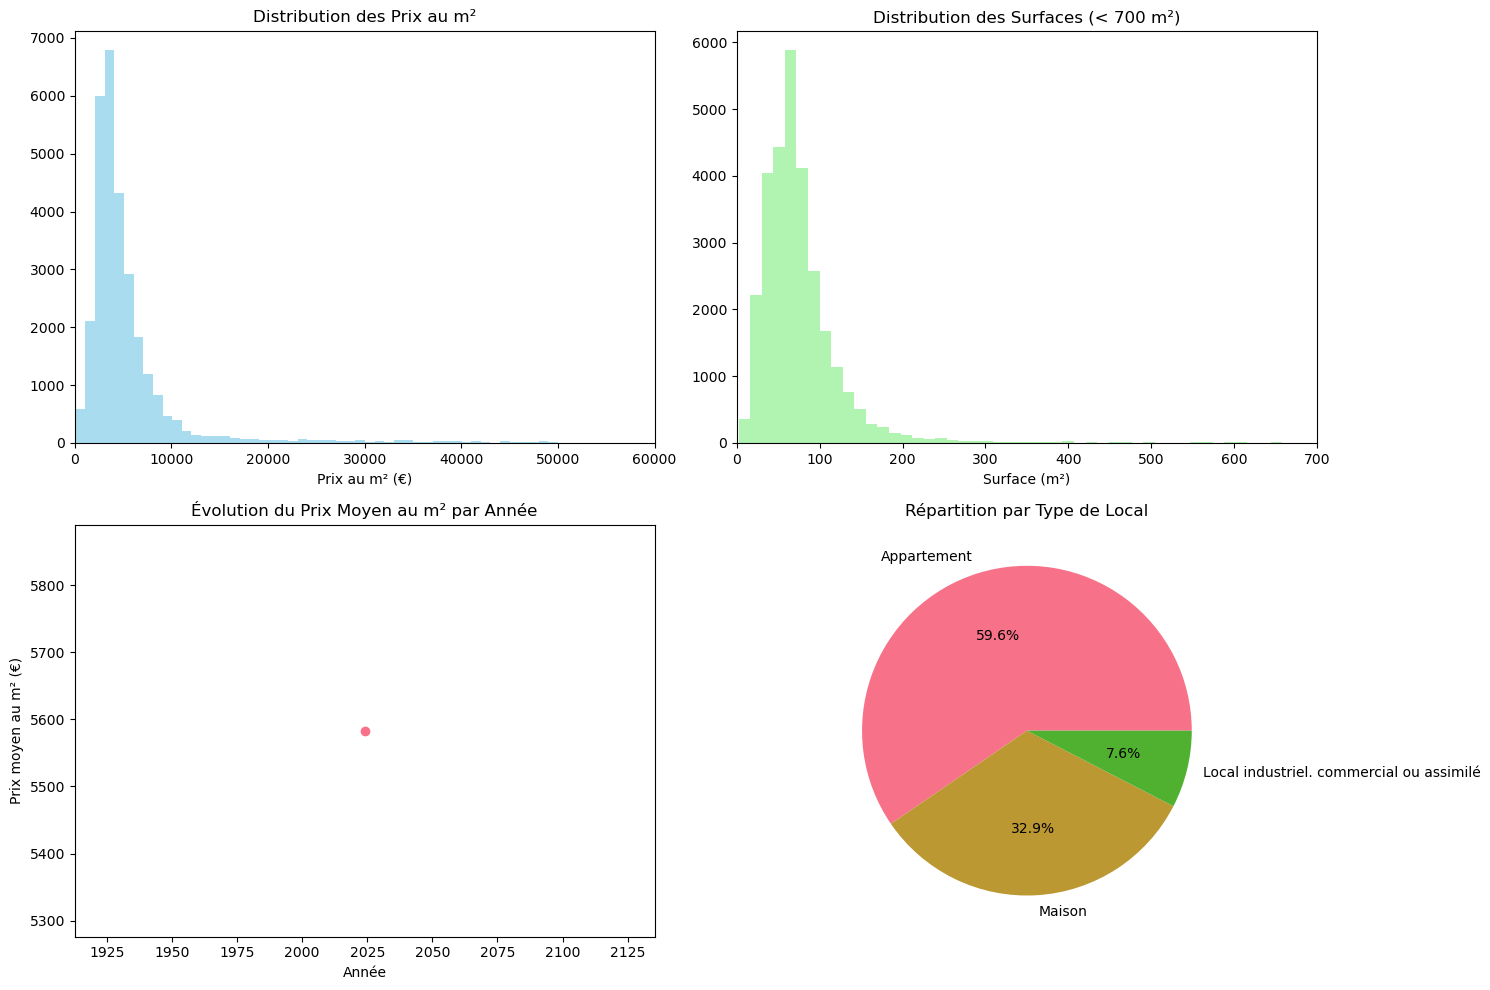

In [ ]:
# Visualisation des distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution des prix au m²
axes[0, 0].hist(df_clean['prix_m2'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution des Prix au m²')
axes[0, 0].set_xlabel('Prix au m² (€)')
axes[0,0].set_xlim(0, 60000)

# Distribution des surfaces
filtre = df_clean[df_clean['surface_reelle_bati'] <= 700]['surface_reelle_bati']
axes[0, 1].hist(filtre, bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Distribution des Surfaces (< 700 m²)')
axes[0, 1].set_xlabel('Surface (m²)')
axes[0, 1].set_xlim(0, 700)

print(df_clean['surface_reelle_bati'].describe())


# Évolution par année PAS NECESSAIRE
yearly_stats = df_clean.groupby('annee_mutation')['prix_m2'].mean()
axes[1, 0].plot(yearly_stats.index, yearly_stats.values, marker='o')
axes[1, 0].set_title('Évolution du Prix Moyen au m² par Année')
axes[1, 0].set_xlabel('Année')
axes[1, 0].set_ylabel('Prix moyen au m² (€)')

# Répartition par type de local
if 'type_local' in df_clean.columns:
    type_counts = df_clean['type_local'].value_counts()
    axes[1, 1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
    axes[1, 1].set_title('Répartition par Type de Local')

plt.tight_layout()
plt.show()

In [34]:
# Vérification de la cohérence des données
print("🔍 Vérifications de Cohérence :")

# Vérification des valeurs négatives
negative_checks = {
    'valeur_fonciere': (df_clean['valeur_fonciere'] <= 0).sum(),
    'surface_reelle_bati': (df_clean['surface_reelle_bati'] <= 0).sum(),
    'prix_m2': (df_clean['prix_m2'] <= 0).sum()
}

for var, count in negative_checks.items():
    status = "✅" if count == 0 else "❌"
    print(f"   {status} {var}: {count} valeurs négatives ou nulles")

# Vérification des outliers extrêmes
prix_m2_q99 = df_clean['prix_m2'].quantile(0.99)
prix_m2_q01 = df_clean['prix_m2'].quantile(0.01)
print(f"\n📊 Prix au m² - Plage interquantile 1%-99% : {prix_m2_q01:.0f}€ - {prix_m2_q99:.0f}€")

# Statistiques par département (top 10)
if 'code_departement' in df_clean.columns:
    commune_stats = (df_clean.groupby('nom_commune')['prix_m2']
                  .agg(['mean', 'count'])
                  .sort_values('mean', ascending=False)
                  .head(10))
    
    print("\n🏆 Top villes - Prix Moyen au m² :")
    for nom_commune, row in commune_stats.iterrows():
        print(f"   • Ville: {nom_commune}: {row['mean']:.0f}€/m² ({row['count']} transactions)")

🔍 Vérifications de Cohérence :
   ✅ valeur_fonciere: 0 valeurs négatives ou nulles
   ✅ surface_reelle_bati: 0 valeurs négatives ou nulles
   ✅ prix_m2: 0 valeurs négatives ou nulles

📊 Prix au m² - Plage interquantile 1%-99% : 794€ - 38090€

🏆 Top villes - Prix Moyen au m² :
   • Ville: Villeneuve-Saint-Georges: 12084€/m² (310.0 transactions)
   • Ville: Saint-Yon: 11457€/m² (15.0 transactions)
   • Ville: Vincennes: 10349€/m² (830.0 transactions)
   • Ville: Fontenay-sous-Bois: 9704€/m² (625.0 transactions)
   • Ville: Saint-Mandé: 9679€/m² (312.0 transactions)
   • Ville: Gentilly: 9253€/m² (142.0 transactions)
   • Ville: Saint-Maur-des-Fossés: 7994€/m² (1272.0 transactions)
   • Ville: Chilly-Mazarin: 7530€/m² (349.0 transactions)
   • Ville: Authon-la-Plaine: 7485€/m² (4.0 transactions)
   • Ville: Champigny-sur-Marne: 7465€/m² (712.0 transactions)


## 6. 💾 Export des Données Nettoyées

Sauvegarde du dataset nettoyé pour les analyses suivantes.

In [22]:
# Création du dossier outputs s'il n'existe pas
output_dir = Path('../outputs')
output_dir.mkdir(exist_ok=True)

# Export du dataset nettoyé
output_file = output_dir / 'dvf_cleaned_2024.csv'
df_clean.to_csv(output_file, index=False)

print(f"✅ Dataset nettoyé exporté : {output_file}")
print(f"📊 Dimensions finales : {df_clean.shape}")

# Sauvegarde des métadonnées
metadata = {
    'date_processing': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'original_rows': cleaning_report['original_rows'],
    'final_rows': df_clean.shape[0],
    'final_columns': df_clean.shape[1],
    'period_analyzed': '2024-2024',
    'key_columns': essential_cols
}

metadata_file = output_dir / 'preprocessing_metadata.json'
import json
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"📋 Métadonnées sauvegardées : {metadata_file}")

✅ Dataset nettoyé exporté : ..\outputs\dvf_cleaned_2024.csv
📊 Dimensions finales : (29427, 46)
📋 Métadonnées sauvegardées : ..\outputs\preprocessing_metadata.json


## 📝 Résumé du Preprocessing

### ✅ Étapes Réalisées

1. **Chargement** : Import des données DVF brutes (85,065 lignes originales)
2. **Nettoyage** : Suppression des valeurs manquantes critiques (65.41% de données supprimées)
3. **Filtrage temporel** : Données 2024 conservées (période disponible dans le dataset)
4. **Variables dérivées** : Prix au m², catégories de surface et prix, variables temporelles
5. **Validation** : Vérification de la cohérence des données (0 valeurs négatives)
6. **Export** : Sauvegarde du dataset nettoyé (29,427 lignes finales)

### 📊 Données Finales

- **Période** : 2024 (données disponibles)
- **Lignes conservées** : 29,427 sur 85,065 originales
- **Variables clés** : valeur_fonciere, surface_reelle_bati, prix_m2, variables temporelles
- **Fichier de sortie** : `../outputs/dvf_cleaned_2024.csv`
- **Types de biens** : 59.6% Appartements, 32.9% Maisons, 7.6% Locaux commerciaux
- **Prix moyen au m²** : 5,583€ (médiane: 3,955€)

### 🛠️ Test des Fonctions Utilitaires

```python
# Test des fonctions de base
print("🧪 Test des fonctions utilitaires...")

# Test du chargement de données
test_data = load_dvf_data('../assets/dataset.csv')
print(f"   ✅ Chargement: {test_data.shape[0]:,} lignes")

# Test du processeur
test_processor = DVFDataProcessor(test_data.head(1000))
test_clean = test_processor.clean_data(start_year=2024, end_year=2024)
print(f"   ✅ Nettoyage: {len(test_clean)} lignes conservées sur 1000")

# Test de l'analyseur géographique
geo_analyzer = GeographicAnalyzer()
top_communes = geo_analyzer.get_top_communes(df_clean, metric='prix_m2', n_top=5)
print(f"   ✅ Analyse géo: Top 5 communes identifiées")

print("✅ Toutes les fonctions utilitaires fonctionnent correctement!")
```

### 🎯 Prochaines Étapes

Les données sont maintenant prêtes pour :
- **Application notebook** : Analyse unifiée avec dashboard interactif
- **Visualisations** : Graphiques matplotlib avec widgets ipywidgets 
- **Recommandations d'investissement** : Basées sur les données DVF 2024

### 📁 Fichiers Générés

- `outputs/dvf_cleaned_2024.csv` : Dataset nettoyé (29,427 transactions)
- `outputs/preprocessing_metadata.json` : Métadonnées du traitement
- `src/dvf_utils.py` : Fonctions utilitaires pour l'analyse DVF